In [51]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

import seaborn as sns


In [52]:
df = pd.read_csv(r"C:/Users/DELL/Desktop/temp/Winequality.csv")
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [53]:
# Quick check
print(df.shape)
print(df['quality'].value_counts().sort_index())
df.isnull().sum()





(1599, 12)
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [54]:
X = df.drop(columns=['quality'])
y = df['quality']
print("done")

done


In [55]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [56]:
# Scale features (important for GMM)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)



In [57]:
# 3. Choose number of components: try range and use BIC/AIC
n_range = range(1, 11)   # try 1..10
bics = []
aics = []
gmm_models = {}

for n in n_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42, n_init=5)
    gmm.fit(X_train_s)
    bics.append(gmm.bic(X_train_s))
    aics.append(gmm.aic(X_train_s))
    gmm_models[n] = gmm

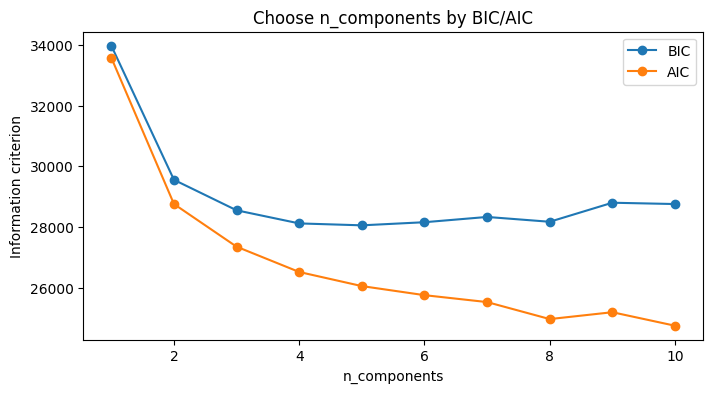

In [58]:
# Plot BIC/AIC
plt.figure(figsize=(8,4))
plt.plot(n_range, bics, label='BIC', marker='o')
plt.plot(n_range, aics, label='AIC', marker='o')
plt.xlabel('n_components')
plt.ylabel('Information criterion')
plt.legend()
plt.title('Choose n_components by BIC/AIC')
plt.show()


In [59]:
# Pick n with lowest BIC (or choose n equal to distinct labels)
best_n = n_range[np.argmin(bics)]
print("Best n by BIC:", best_n)
# 4. Fit best-GMM
gmm = gmm_models[best_n]

Best n by BIC: 5


In [60]:
# Get hard assignment and soft responsibilities
train_comp = gmm.predict(X_train_s)          # component labels for train
test_comp = gmm.predict(X_test_s)
train_resp = gmm.predict_proba(X_train_s)    # responsibilities (N x K)
test_resp = gmm.predict_proba(X_test_s)

Method C - classifier on GMM-posteriors accuracy: 0.65625
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.50      0.09      0.15        11
           5       0.71      0.76      0.73       136
           6       0.61      0.67      0.64       128
           7       0.64      0.45      0.53        40
           8       1.00      0.33      0.50         3

    accuracy                           0.66       320
   macro avg       0.58      0.39      0.43       320
weighted avg       0.65      0.66      0.64       320



C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

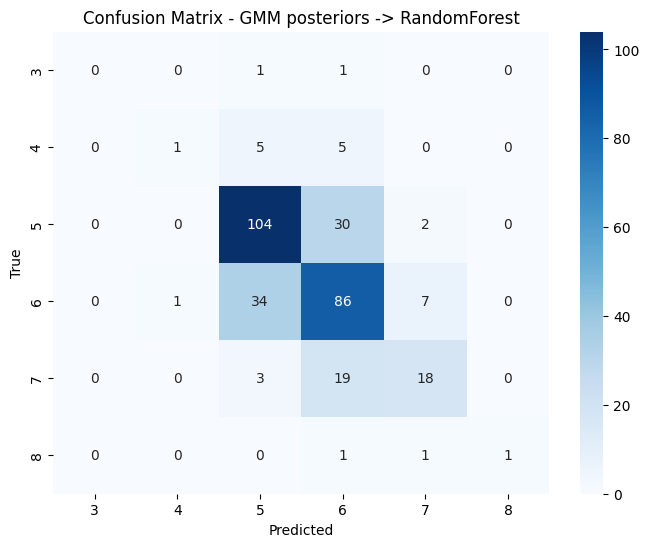

In [61]:
# Method C: use GMM responsibilities as features and train a simple classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(train_resp, y_train)
y_pred_C = clf.predict(test_resp)
print("Method C - classifier on GMM-posteriors accuracy:", accuracy_score(y_test, y_pred_C))
print(classification_report(y_test, y_pred_C))

# Confusion matrix (for best method, say C)
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred_C, labels=np.sort(y.unique()))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.sort(y.unique()), yticklabels=np.sort(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GMM posteriors -> RandomForest')
plt.show()

In [62]:
#collapse labels
def collapse_labels(q):
    if q in [3,4]:
        return 0  # Low
    elif q in [5,6]:
        return 1  # Medium
    else:  # 7,8
        return 2  # High

y = y.apply(collapse_labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Step 1: Tune GMM with BIC
best_score = -np.inf
best_gmm = None

for n in [4, 6, 8, 10]:
    for cov in ["full", "diag", "tied", "spherical"]:
        gmm = GaussianMixture(n_components=n, covariance_type=cov,
                              n_init=5, random_state=42)
        gmm.fit(X_train_s)
        bic = -gmm.bic(X_train_s)  # using negative so we maximize
        if bic > best_score:
            best_score = bic
            best_gmm = gmm

print("Best GMM params:", best_gmm.n_components, best_gmm.covariance_type)

# Posterior features
train_resp = best_gmm.predict_proba(X_train_s)
test_resp = best_gmm.predict_proba(X_test_s)

# Step 2: Tune RandomForest
rf = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(rf, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
grid.fit(train_resp, y_train)

print("Best RF params:", grid.best_params_)

# Evaluate
best_rf = grid.best_estimator_
y_pred = best_rf.predict(test_resp)

print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Best GMM params: 6 full
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500}
Final Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.88      0.95      0.91       264
           2       0.62      0.49      0.55        43

    accuracy                           0.85       320
   macro avg       0.50      0.48      0.49       320
weighted avg       0.81      0.85      0.83       320



C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [63]:
rf = RandomForestClassifier(class_weight="balanced", random_state=42)


In [64]:
# Fit RF with balanced class weights
rf_balanced = RandomForestClassifier(class_weight="balanced", 
                                     n_estimators=500, 
                                     max_depth=10, 
                                     min_samples_split=2, 
                                     random_state=42)
rf_balanced.fit(train_resp, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=500,
                       random_state=42)

In [65]:
y_pred_balanced = rf_balanced.predict(test_resp)


In [66]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred_balanced)
print("Balanced RF Accuracy:", acc)


Balanced RF Accuracy: 0.859375


Classification Report:

              precision    recall  f1-score   support

           0       0.20      0.08      0.11        13
           1       0.91      0.92      0.92       264
           2       0.62      0.70      0.66        43

    accuracy                           0.86       320
   macro avg       0.58      0.57      0.56       320
weighted avg       0.85      0.86      0.85       320



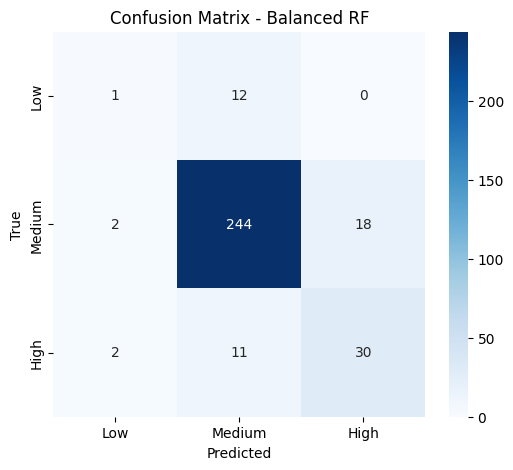

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:\n")
print(classification_report(y_test, y_pred_balanced))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_balanced, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Low","Medium","High"], yticklabels=["Low","Medium","High"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Balanced RF")
plt.show()


In [68]:
import joblib
# Save GMM
joblib.dump(best_gmm, "gmm_model.pkl")

# Save RandomForest (balanced)
joblib.dump(rf_balanced, "rf_model.pkl")

# Optional: save the scaler too (important if you want to scale new data the same way)
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']